# Recommendation System -- Top 10 Products for Amazon

## Context

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what’s most likely to keep them engaged and help business. 

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalised recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analysing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.


## Objective
You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labelled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.


## Data Dictionary
The Amazon dataset contains the following attributes:

- userId: Every user identified with a unique id
- productId: Every product identified with a unique id
- Rating: The rating of the corresponding product by the corresponding user
- timestamp: Time of the rating. We will not use this column to solve the current problem

# Data Loading

In [2]:
# install libraries

%pip install scikit-surprise
%pip install torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# base libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ml
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

# error handling
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print(f'NumPy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')
print('All libraries imported successfully!')

NumPy version: 1.26.4
Pandas version: 2.2.2
All libraries imported successfully!


In [4]:
# import data
data = pd.read_csv("/Users/lukeroberts/My Drive(lukejrobertsza@gmail.com)/Colab Notebooks/mit_adsp_notebooks/7.1.elective_project/ratings_Electronics.csv")

In [5]:
# copy the data
copy_of_data = data.copy()

In [6]:
data.shape

(7824481, 4)

In [7]:
data

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600
...,...,...,...,...
7824476,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824477,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824478,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824479,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200


In [8]:
# Assign column headers without replacing the first row
data.columns = ['user', 'item', 'rating', 'timestamp']
copy_of_data.columns = ['user', 'item', 'rating', 'timestamp']

In [9]:
data.shape

(7824481, 4)

In [10]:
# check the first row has not been replaced
data[data['user'] == 'AKM1MP6P0OYPR']

,user,item,rating,timestamp
5200190,AKM1MP6P0OYPR,B005UEB5TQ,5.0,1366243200


Observations

- the dataset has 7,824,484 rows and 4 columns
- the columns have headings, and have been renamed according to the descriptions given
- - 'user', 'item', 'rating', 'timestamp'



In [35]:
# loop through data and return unique values


for col in data.columns:
	unique_vals = data[col].unique()
	print(f"{col}: unique values = {len(unique_vals)} ({round(len(unique_vals) / data.shape[0], 2)})")


user: unique values = 4201696 (0.54)
item: unique values = 476001 (0.06)
rating: unique values = 5 (0.0)
timestamp: unique values = 5489 (0.0)
rating: unique values = 5 (0.0)
timestamp: unique values = 5489 (0.0)


Observations
- 54% of users are unique, meaning on average each user rated roughly twice
- most items are unique

In [12]:
# inspect dataset size
data_size_gb = data.memory_usage(deep=True).sum() / (1024 ** 3)
print(f"Data size: {data_size_gb:.2f} GB")
data_size_mb = data.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"Data size: {data_size_mb:.2f} MB")

Data size: 1.00 GB
Data size: 1027.83 MB


Observations
- the dataset is 1GB once imported
- this is computationally expensive to build a model off the entire data set right now
- consider reducing the dataset to build and explore
- - possibly train final model on full dataset

## Data Cleaning & Preperation

In [13]:
# lets view ratings by user to determine where to set the threshold

data_groupby_user_count_rating = data.groupby('user')['rating'].count().sort_values(ascending=False)

In [14]:
data_groupby_user_count_rating

user
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A2HRB8UOXH92SQ      1
A2HRBA4HO2E4GU      1
A2HRBCM00IDK56      1
A2HRBEBDTIB8MT      1
AZZZY1W55XHZR       1
Name: rating, Length: 4201696, dtype: int64

In [15]:
data_groupby_user_count_rating.sum()

7824481

Observations
- the length of the ratings_count dictionary is equal to the length of the unique values of users (4201696)
- - this makes sense as each user will have at least one rating
- the total of the dictionary values, i.e. the sum of all ratings is equal to the length of data (7824481)
- this step helps us understand user engagement and will be useful for filtering users with very few ratings

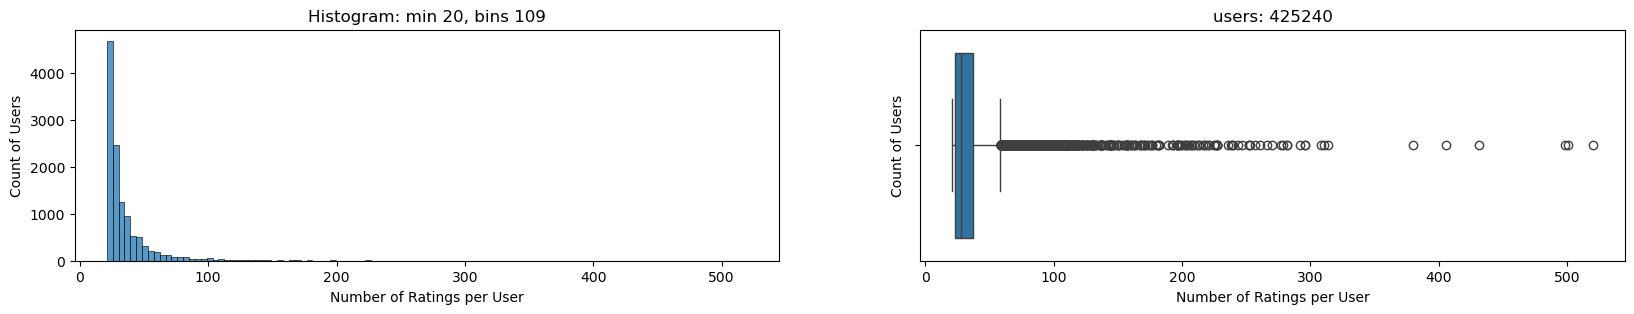

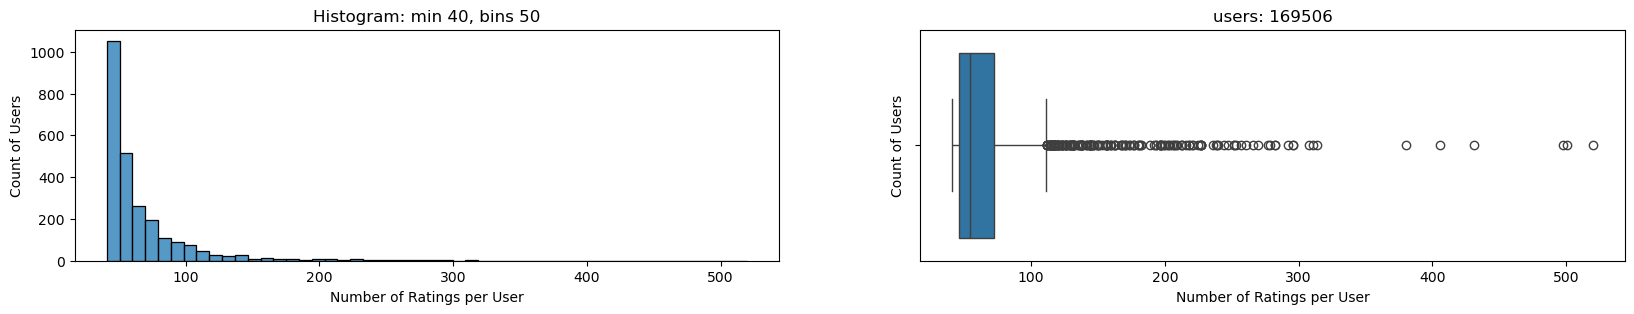

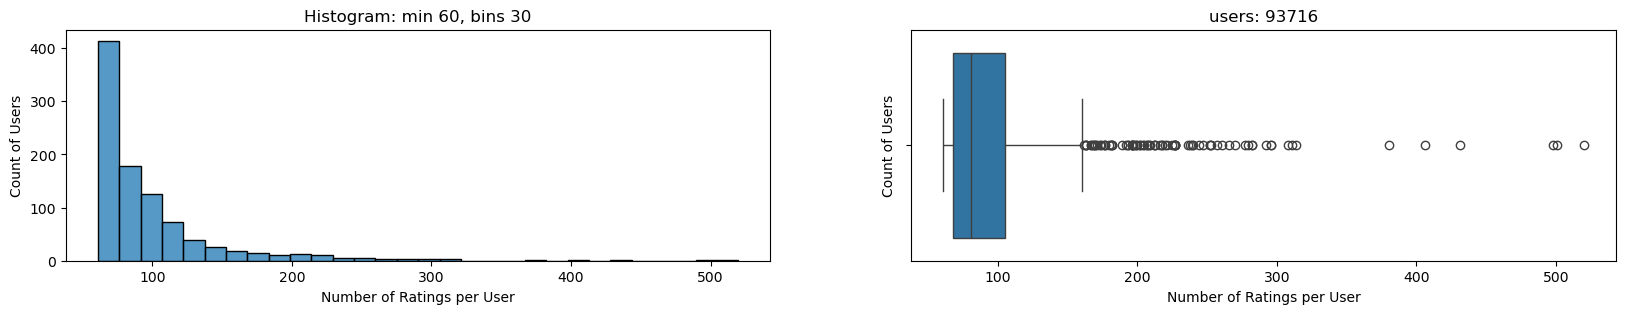

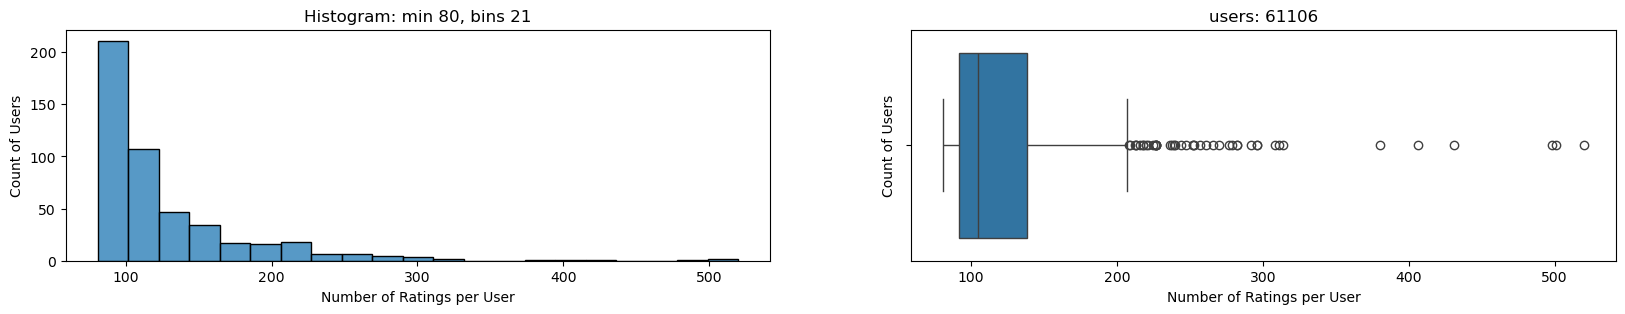

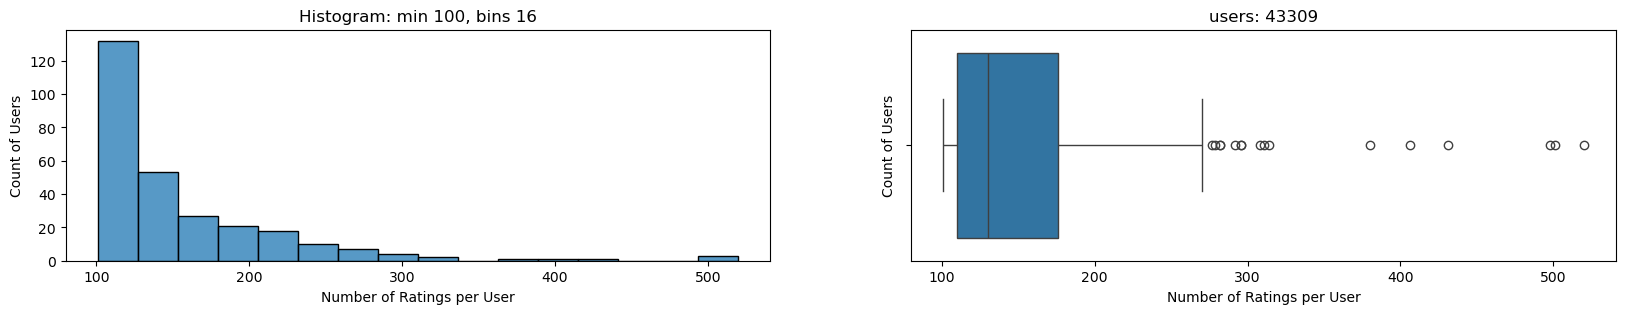

In [16]:
# plot of different thresholds

for threshold in range(20, 120, 20):
    plot_threshold = threshold
    filtered_data = data_groupby_user_count_rating[data_groupby_user_count_rating > plot_threshold]
    optimal_bins = int(np.sqrt(len(filtered_data)))

    # set figure
    fig, axes = plt.subplots(1, 2, figsize=(20, 3))
    
    # Histogram
    sns.histplot(data=filtered_data, bins=optimal_bins, ax=axes[0])
    axes[0].set_xlabel('Number of Ratings per User')
    axes[0].set_ylabel('Count of Users')
    axes[0].set_title(f'Histogram: min {threshold}, bins {optimal_bins}')
    
    # Boxplot
    sns.boxplot(x=filtered_data.values, ax=axes[1])
    axes[1].set_xlabel('Number of Ratings per User')
    axes[1].set_title(f'Boxplot: min {threshold}')

    # plot
    plt.xlabel('Number of Ratings per User')
    plt.ylabel('Count of Users')
    plt.title(f'users: {data_groupby_user_count_rating[data_groupby_user_count_rating > plot_threshold].sum()}')
    plt.show()

## Filtering

In [17]:
data.head(1)

,user,item,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800


In [18]:
stop 

NameError: name 'stop' is not defined

### User Filtering

In [30]:
data.shape

(7824481, 4)

In [29]:
# data frame of who meet the threshold

user_filter = data.groupby('user')['rating'].count()
user_filter

user
A00000262KYZUE4J55XGL    1
A000063614T1OE0BUSKUT    2
A00009182QVLSWIGHLS1B    1
A00009661LC9LQPGKJ24G    1
A00010809P09NUU6ZP6H     1
                        ..
AZZZOVIBXHGDR            3
AZZZRS1YZ8HVP            2
AZZZSIK7NFFVP            1
AZZZWXXUPZ1F3            1
AZZZY1W55XHZR            1
Name: rating, Length: 4201696, dtype: int64

In [ ]:
# Calculate sparsity of the dataframe 'data'
num_users = data['user'].nunique()
num_items = data['item'].nunique()
num_ratings = len(data)
sparsity = 1 - (num_ratings / (num_users * num_items))
print(f"Sparsity of 'data': {sparsity:.4f}")

In [36]:
# Calculate sparsity of the cleaned final dataset
num_users = data_cleaned_final['user'].nunique()
num_items = data_cleaned_final['item'].nunique()
num_ratings = len(data_cleaned_final)
sparsity = 1 - (num_ratings / (num_users * num_items))
print(f"Sparsity of 'data_cleaned_final': {sparsity:.4f}")

# Also show comparison with original data
print(f"\nComparison:")
print(f"Original data sparsity: {1 - (len(data) / (data['user'].nunique() * data['item'].nunique())):.4f}")
print(f"Cleaned data sparsity: {sparsity:.4f}")

Sparsity of 'data_cleaned_final': 0.9992

Comparison:
Original data sparsity: 1.0000
Cleaned data sparsity: 0.9992
Original data sparsity: 1.0000
Cleaned data sparsity: 0.9992


Observations
- after cleaing the data the sparsity is improved to 99.96%
- this is within industry standard ranges 

# Model Building

## Model 1 - RANK BASED RECSYS

Framework
1. calculate ave rating for all items
2. calc count of ratings for each item
3. create a df of the above two metrics
4. sort df in descedning order
5. inspect the first 5 rows

In [ ]:
# 1. average rating for all items

avg_rating_per_item = data_cleaned_final.groupby('item')['rating'].mean()
avg_rating_per_item

In [ ]:
# 2. count of ratings per item

count_ratings_per_item = data_cleaned_final.groupby('item')['rating'].count()
count_ratings_per_item

In [ ]:
# 3. create a df of the average and count metrics above
average_count_ratings_dataframe = pd.DataFrame({
    'avg_rating': avg_rating_per_item,
    'count_ratings': count_ratings_per_item
})

average_count_ratings_dataframe